<a href="https://colab.research.google.com/github/MayerT1/Sewanee_Colab/blob/main/Copy_of_occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc arviz numpy pandas matplotlib scikit-learn

In [ ]:
!pip install pymc-extras

(occupancy)=
# Estimating species distributions with occupancy models

:::{post} January, 2026
:tags: ecology, hierarchical model, marginalization
:category: intermediate, howto
:author: Philip T. Patton
:::

Estimating where species live is one of the most common tasks in ecology. Recreational birders know that every field guide includes a range map showing where a species can be found, as well as habitat information to help locate the animals. For example, a field guide for Swiss birds might tell you that Red Crossbills (*Loxia curvirostra*) are most likely found in forests at intermediate elevations. Both of these tasks--mapping ranges and estimating habitat relationships--fall under the umbrella of *species distribution modeling*.

One of the biggest challenges in species distribution modeling, and wildlife science in general, is that the probability of detection is almost universally less than one. That is, just because you didn't see or hear a crossbill on your morning hike doesn't mean that one wasn't there. This minor annoyance for birders can be a headache for wildlife managers. Species distributions models that assume the detection probability is one will underestimate the true occurrence probability, potentially misleading wildlife managers.

In this notebook, we will demonstrate how model species distributions with site occupancy models {cite:p}`mackenzie2002occupancy`. Occupancy models treat the underlying true occurrence state--whether a species is at a site--as a binary latent variable. We will marginalize this latent variable with {ref}`automated marginalization <marginalizing-models>`, a handy tool from `pymc-extras`.

We will use an example of Red Crossbills in Switzerland. The data are included in the R package, [unmarked](https://cran.r-project.org/web/packages/unmarked/vignettes//spp-dist.html), and come from the Swiss Breeding Bird Survey (MHB) {cite:p}`schmid2004mhb`. Red Crossbills use their distinctive bills to pry open pine cones and eat the seeds. Unsurprisingly, they like pine forests, which tend to be found at mid-elevations in Switzerland. This notebook essentially reproduces the analysis in this [unmarked vignette](https://cran.r-project.org/web/packages/unmarked/vignettes//spp-dist.html)

![Two male Red Crossbills, showing their distinctive bill shape and preferred food. Image: NaturesPicsOnline.com, via Wikimedia Commons. Licensed under CC BY-SA 3.0.](https://github.com/pymc-devs/pymc-examples/blob/main/examples/case_studies/Red_Crossbills_(Male).jpg?raw=1)


In [ ]:
import os

import arviz as az  # <---------------------note changed issue
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import colors
from matplotlib.ticker import PercentFormatter


def scale(x):
    """Standardize a variable with the z-score."""
    return (x - x.mean()) / x.std()


def invlogit(x):
    """Take the inverse logit, or expit, of a variable"""
    return 1 / (1 + np.exp(-x))

:::{include} ../extra_installs.md
:::

In [ ]:
import pymc_extras as pmx

In [ ]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
# az.style.use('seaborn-darkgrid')
az.style.use("arviz-darkgrid")
RANDOM_SEED = 1792
rng = np.random.default_rng(RANDOM_SEED)

## Site occupancy model

During the MHB, researchers surveyed 267 1km $^2$ quadrats up to 3 times. During each survey, researchers either detect crossbills $y_{ij}=1$, or they don't, $y_{ij}=0$, where $i$ is an index for the quadrat and $j$ is an index for the survey. We assume that crossbills are detected with probability $p_{ij}$ at quadrats they occupy, $z_i=1$, and are never detected at quadrats they do not occupy, $z_i=0,$ where $z_i$ is the true occupancy state at quadrat $i$. In other words, we assume no false positives errors. We assume that the probability of detection depends a linear effect of day of year (note that that all surveys took place from January to April) via a logit-linear model. See below for a visualization of the covariates. Additionally, we assume that the probability that a crossbill occupies a quadrat, $\psi_i$, depends on the forest cover and a quadratic effect of elevation via a logit-linear model. All told, the model can be written as
$$
\begin{align*}
\alpha_0, \alpha_1 &\sim \text{Normal}(0, 2) \\
\beta_0, \beta_1, \beta_2, \beta_3 &\sim \text{Normal}(0, 2) \\
p_{ij}&=\text{logit}^{-1}(\alpha_0 + \alpha_1\mathrm{date}_{ij}) \\
\psi_{i}&=\text{logit}^{-1}(\beta_0 + \beta_1\mathrm{forest\_cover}_{i} + \beta_2\mathrm{elevation}_{i} + \beta_3\mathrm{elevation}^2_{i}) \\
z_{i} &\sim \text{Bernoulli}\left(\psi_i\right) \\
y_{ij} &\sim \text{Bernoulli}\left(p_{ij}z_i\right),
\end{align*}
$$
where $\alpha$ and $\beta$ represent the effects on detection and occupancy.

In [ ]:
try:
    mhb_data = pd.read_csv(os.path.join("..", "data", "crossbill.csv"))
except FileNotFoundError:
    mhb_data = pd.read_csv(pm.get_data("crossbill.csv"))

While `mhb_data` contains data from multiple years of surveys, we will focus on the data from 2001. In this exercise, we'll remove quadrats that have missing surveys. Theoretically, one could flatten the data, such that `y` is one dimensional, to deal with missing surveys. In my testing, however, doing so causes `pmx.marginalize()` to throw an error.

In [ ]:
year = 2001

# remove quadrats with missing surveys
is_y_column = mhb_data.columns.str.startswith(f"det{str(year)[2:]}")
y = mhb_data.loc[:, is_y_column].values
was_surveyed = ~np.isnan(y).any(axis=1)
y = y[was_surveyed].astype(int)
quadrat_count, survey_count = y.shape

# extract our covariates
elevation = mhb_data["ele"].values[was_surveyed]
forest_cover = mhb_data["forest"].values[was_surveyed]
is_date_column = mhb_data.columns.str.startswith(f"date{str(year)[2:]}")
date = mhb_data.loc[:, is_date_column].values[was_surveyed]

# prepare design matrix for the occurrence model
elev_scaled = scale(elevation)
forest_scaled = scale(forest_cover)
elev_scaled2 = elev_scaled**2
X = np.column_stack((np.ones_like(elevation), forest_scaled, elev_scaled, elev_scaled2))

# some dates are missing so we'll impute those
date[np.isnan(date)] = np.nanmedian(date)
W = np.stack((np.ones_like(date), date), axis=2)

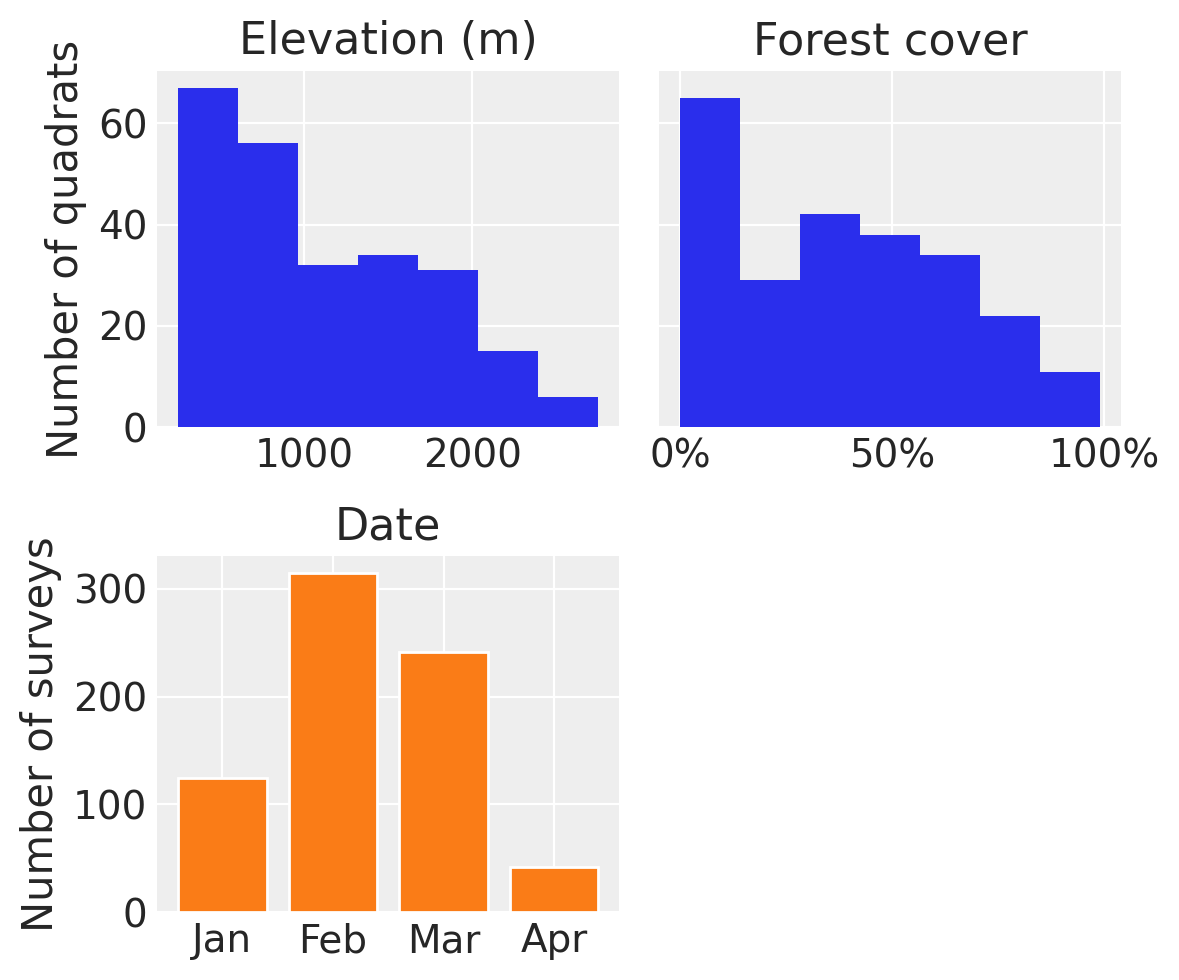

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), tight_layout=True, sharey="row")

ax = axes.flat[0]
ax.hist(elevation, ec="w", bins=7)
ax.set_ylabel("Number of quadrats")
ax.set_title("Elevation (m)")

ax = axes.flat[1]
ax.hist(forest_cover, ec="w", bins=7, fc="C2")
ax.set_title("Forest cover")
ax.xaxis.set_major_formatter(PercentFormatter())

ax = axes.flat[2]
real_date = np.datetime64("2001-01-01") + (date - 1).astype("timedelta64[D]")
df = pd.DataFrame({"date": real_date.flat})
monthly_counts = df.groupby(df["date"].dt.to_period("M")).size()
ax.bar(monthly_counts.index.strftime("%b"), monthly_counts.values, ec="w", fc="C1")
ax.set_ylabel("Number of surveys")
ax.set_title("Date")

axes.flat[3].remove()

# plt.show()

The PyMC syntax for the model is quite concise. The only trick is to broadcast the `z` vector across the `p` matrix. The `coords` are not necessary here, but they do help improve the readability of the code and the ArviZ output.

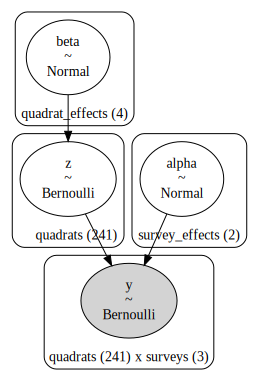

In [ ]:
coords = {
    "survey_effects": ["intercept", "date"],
    "quadrat_effects": ["intercept", "forest_cover", "elevation", "elevation2"],
    "quadrats": np.arange(quadrat_count),
    "surveys": np.arange(survey_count),
}

with pm.Model(coords=coords) as occupancy:

    # occurrence probability model
    beta = pm.Normal("beta", 0, 2, dims="quadrat_effects")
    occurrence_probability = pm.math.invlogit(pm.math.dot(X, beta))

    # detection probability model
    alpha = pm.Normal("alpha", 0, 2, dims="survey_effects")
    detection_probability = pm.math.invlogit(pm.math.dot(W, alpha))

    # occupied / unoccupied state at each site
    z = pm.Bernoulli("z", occurrence_probability, dims="quadrats")

    # likelihood
    pm.Bernoulli("y", z[:, None] * detection_probability, dims=["quadrats", "surveys"], observed=y)

pm.model_to_graphviz(occupancy)

While coding the model up this way, i.e., with the discrete latent state `z`, makes the code readable and concise, it does mean that we cannot sample every model parameter with NUTS. We can get around this with the handy `marginalize` function from `pymc_extras`.

In [ ]:
# marginalize the model before sampling
occupancy_marginal = pmx.marginalize(occupancy, ["z"])
with occupancy_marginal:
    occupancy_idata = pm.sample(random_seed=RANDOM_SEED)

az.summary(occupancy_idata)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[intercept],-0.654,0.485,-1.537,0.284,0.015,0.011,989.0,1196.0,1.0
alpha[date],0.016,0.007,0.002,0.029,0.000,0.000,1001.0,1222.0,1.0
beta[intercept],-0.680,0.278,-1.188,-0.160,0.007,0.006,1584.0,1360.0,1.0
beta[forest_cover],0.445,0.227,0.050,0.900,0.006,0.005,1480.0,1289.0,1.0
beta[elevation],1.800,0.344,1.169,2.432,0.009,0.009,1417.0,963.0,1.0
beta[elevation2],-1.107,0.293,-1.684,-0.609,0.008,0.007,1273.0,1225.0,1.0


The marginalized model samples quickly and there do not appear to be any convergence issues. The `alpha[date]` parameter looks a oddly small and precise, especially relative to the intercept, but note that median date value was 51 (February 20th, 2001).

In [ ]:
# import arviz.preview as az

az.plot_rank_dist(occupancy_idata)

AttributeError: module 'arviz' has no attribute 'plot_rank_dist'

We can evaluate the model fit with a posterior predictive check. In this case, we'll use the number of sites with at least one detection as the test statistic.

In [ ]:
# get the posterior predictive distribution for the in sample data
with occupancy_marginal:
    predictions = pm.sample_posterior_predictive(
        occupancy_idata, predictions=True, random_seed=RANDOM_SEED
    ).predictions

# compute the test statistic with the samples
y_pred = az.extract(predictions)
was_detected = y_pred.sum(axis=1) > 1
quadrats_with_detection_pred = was_detected.sum(axis=0)

# compute a bayesian p value with the observed value
quadrats_with_detection_obs = sum(y.sum(axis=1) > 1)
sample_count = len(quadrats_with_detection_pred)
p_value = sum(quadrats_with_detection_pred >= quadrats_with_detection_obs) / sample_count

# plot the results
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(quadrats_with_detection_pred, ec="w", bins=23)
ax.axvline(quadrats_with_detection_obs, color="C1", linewidth=4, linestyle="--")
ax.set_ylabel("Sample count")
ax.set_xlabel("Quadrats with a detection")
ax.text(0.9, 0.9, rf"$P$={p_value:0.2f}", ha="right", transform=ax.transAxes, size=14)
ax.set_title("Posterior predictive check")
plt.show()

Output()

ValueError: passing 'axis' to Dataset reduce methods is ambiguous. Please use 'dim' instead.

The model appears to generally overpredict the number of sites with at least one detection. It could be that the model is overestimating the detection probability or overestimating the occurrence probability. Let's investigate the effect of the covariates on the occurrence probability and the detection probability.

In [ ]:
# create scaled values for predictions and corresponding real values for plotting
scaled_elev_plot = np.linspace(min(elev_scaled), max(elev_scaled), 100)
elev_plot = scaled_elev_plot * elevation.std() + elevation.mean()
scaled_forest_plot = np.linspace(min(forest_scaled), max(forest_scaled), 100)
forest_cover_plot = scaled_forest_plot * forest_cover.std() + forest_cover.mean()

# predict the occurrence probability conditional on average values for other predictors
beta = az.extract(occupancy_idata, var_names="beta").values
elev_pred = invlogit(
    beta[0][:, None] + beta[2][:, None] * scaled_elev_plot + beta[3][:, None] * scaled_elev_plot**2
)
forest_pred = invlogit(beta[0][:, None] + beta[1][:, None] * scaled_forest_plot)

# predict the detection probability over the course of the year
alpha = az.extract(occupancy_idata)["alpha"].values
plot_date = np.arange(date.min(), date.max())
p_pred = invlogit(alpha[0][:, None] + alpha[1][:, None] * plot_date)

# convert the day of year to actual dates
base_date = np.datetime64("2001-01-01")
dates = base_date + (plot_date - 1).astype("timedelta64[D]")

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharey=True, layout="constrained")

# plot 1000 samples from the posterior
sample_indices = rng.choice(len(alpha[0]), size=500)
for sample in sample_indices:
    axes[0, 0].plot(elev_plot, elev_pred[sample], alpha=0.05, color="C0")
    axes[0, 1].plot(forest_cover_plot, forest_pred[sample], alpha=0.05, color="C2")
    axes[1, 0].plot(dates, p_pred[sample], color="C1", alpha=0.05)

axes[0, 0].set_ylim((0, 1))

axes[0, 0].set_ylabel(r"Occurrence probability", fontsize=13)
axes[1, 0].set_ylabel(r"Detection probability", fontsize=13)

axes[1, 0].set_title(r"Day of year")
axes[0, 0].set_title("Elevation (m)")
axes[0, 1].set_title("Forest cover")

axes[1, 0].set_xticks(["2001-01-15", "2001-02-15", "2001-03-15", "2001-04-15"])
axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
axes[0, 1].xaxis.set_major_formatter(PercentFormatter())

axes[1, 1].remove()

plt.show()

There is a fair amount of uncertainty in all of the predictions. A more full-fledged analysis might explore the effects of other covariates, different functional forms for the covariate effects (e.g., splines), regularization (e.g., the lasso), or spatial models. Note that this version of the dataset does not include the locations of the quadrats.

## Predicting the species distribution

Now that we've estimated the relationship between these habitat covariates and occurrence at the quadrats, we can predict the distribution of crossbills across Switzerland. To do so, a 1 km $^2$ grid of elevation and forest cover data across Switzerland. These data are also included with the R package [unmarked](https://cran.r-project.org/web/packages/unmarked/vignettes//spp-dist.html).

In [ ]:
try:
    suisse = pd.read_csv(os.path.join("..", "data", "switzerland.csv"))
except FileNotFoundError:
    suisse = pd.read_csv(pm.get_data("switzerland.csv"))

suisse.head()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

ax = axes[0]
scat = ax.scatter(suisse.x, suisse.y, marker="s", s=0.5, c=suisse.elevation, cmap="gist_earth")
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
fig.colorbar(
    scat,
    ax=ax,
    label="Elevation (m)",
)

ax = axes[1]
scat = ax.scatter(suisse.x, suisse.y, marker="s", s=0.5, c=suisse.forest, cmap="YlGn")
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")
fig.colorbar(scat, ax=ax, label="Forest Cover (%)")
plt.ticklabel_format(axis="both", style="sci", scilimits=(4, 4))

plt.show()

Next, we can predict the values of the occurrence probability in each cell. The only potential gotcha here is that we need to scale the values by the mean and the standard deviation of the values at the quadrats, since we used that scaling to fit the model.

In [ ]:
# scale the maps elevation using the mhb statistics
map_elev_scaled = (suisse.elevation.values - elevation.mean()) / elevation.std()
map_forest_scaled = (suisse.forest.values - forest_cover.mean()) / forest_cover.std()

# predict the occurrence probability across the country
psi_tilde_map = invlogit(
    beta[0][:, None]
    + beta[1][:, None] * map_forest_scaled
    + beta[2][:, None] * map_elev_scaled
    + beta[3][:, None] * map_elev_scaled**2
)
eti = az.eti(psi_tilde_map.T, prob=0.9)

suisse["psi_hat"] = psi_tilde_map.mean(axis=0)
suisse["psi_low"] = eti[:, 0]
suisse["psi_high"] = eti[:, 1]
suisse["psi_se"] = np.std(psi_tilde_map, axis=0)

fig, ax = plt.subplots(figsize=(7, 6))

scat = ax.scatter(suisse.x, suisse.y, marker="s", s=1, c=suisse.psi_hat, cmap="viridis")
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")
ax.set_title("Distribution of Red Crossbills in Switzerland")
fig.colorbar(scat, ax=ax, label=r"Occurrence probability $\psi$", fraction=0.03)
plt.ticklabel_format(axis="both", style="sci", scilimits=(4, 4))
plt.show()

We can see that the distribution is fairly heterogenous. We are most likely to find crossbills in the Jura Mountains to the west and the Alps in the south, and are unlikely to ever find them in the Swiss Plateau. We are also unlikely to find them at the highest elevations in the Alps.

It is also helpful to visualize the uncertainty in our estimates by plotting the lower and upper bounds of the credible interval. It can also be helpful to plot the standard error of the predictions by themselves, to highlight uncertain cells.

NameError: name 'eti' is not defined

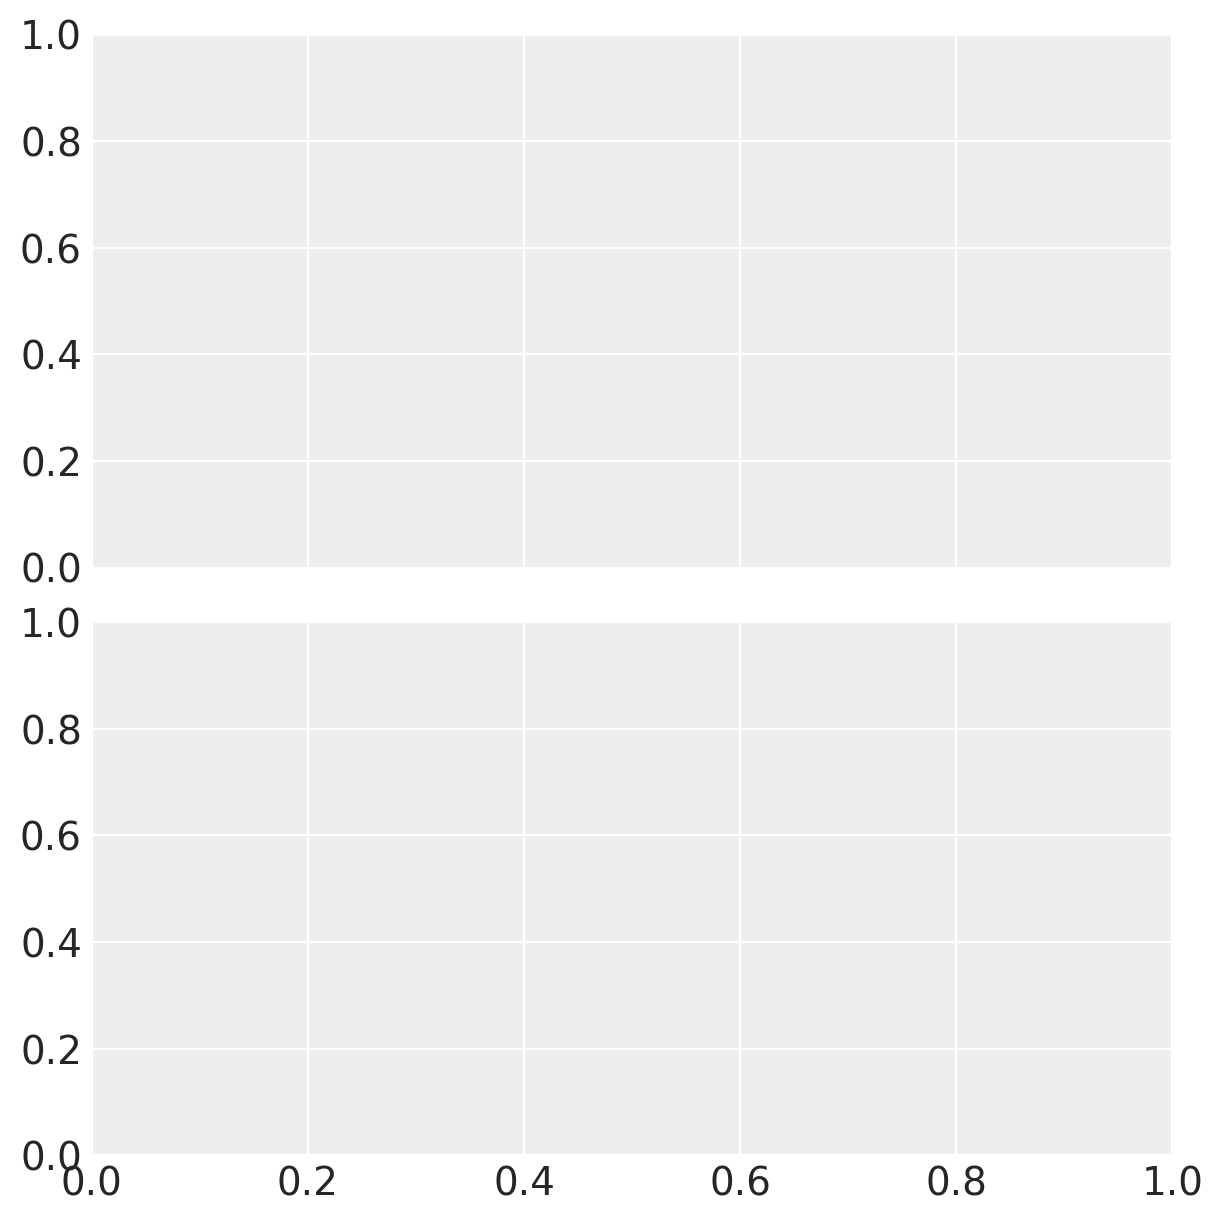

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, sharey=True)

norm = colors.Normalize(vmin=np.min(eti), vmax=np.max(eti))

ax = axes[0]
scat = ax.scatter(
    suisse.x, suisse.y, marker="s", s=0.5, c=suisse.psi_low, cmap="viridis", norm=norm
)
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
ax.set_title("Lower (5%)")

ax = axes[1]
scat = ax.scatter(
    suisse.x, suisse.y, marker="s", s=0.5, c=suisse.psi_high, cmap="viridis", norm=norm
)
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")
ax.set_title("Upper (95%)")
plt.ticklabel_format(axis="both", style="sci", scilimits=(4, 4))

fig.colorbar(
    scat, ax=axes, orientation="vertical", fraction=0.03, label=r"Occurrence probability $\psi$"
)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

scat = ax.scatter(suisse.x, suisse.y, marker="s", s=1, c=suisse.psi_se, cmap="magma")
ax.set_aspect("equal")
ax.set_facecolor("w")
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")
ax.set_title("Standard error")
fig.colorbar(scat, ax=ax, fraction=0.03)
plt.ticklabel_format(axis="both", style="sci", scilimits=(4, 4))
plt.show()

As we saw with the the predictions plots above, there is quite a bit of uncertainty in our predictions. The uncertainty seems to be concentrated in the mid to high elevation forests, i.e., the areas with the highest predicted occupancy.

## Conclusion

In this notebook, we demonstrated how easy it is to code site occupancy models in PyMC, especially when using automated marginalization from `pymc_extras`. From an ecologists perspective, this is encouraging because several common modeling frameworks are structurally quite similar to occupancy models. This includes several models for estimating the size of a closed population, including distance sampling, capture-recapture, and spatial capture-recapture.

## Authors
- Authored by [Philip T. Patton](https://github.com/philpatton) in January 2026

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

:::{include} ../page_footer.md
:::